In [1]:
import os
import math
import time
import datetime
from collections import deque, defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2 as cv
import  albumentations as A
from PIL import Image
from numba import jit


import torch
import torch.utils.data
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

np.random.seed(42)
torch.manual_seed(42)

In [2]:
train = pd.read_csv('../input/global-wheat-detection/train.csv')
train.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [3]:
drop_img_id = ['a1321ca95', '409a8490c', 'd7a02151d', '9a30dd802', \
              '2cc75e9f5', '42e6efaaa', 'd067ac2b1', '41c0123cc']

train = train[~(train['image_id'].isin(drop_img_id))]

In [4]:
def bbox_area(bbox, format='coco'):
    
    assert format in ['coco', 'pascal_voc']
    
    area = None
    if format == 'coco':
        area = bbox[2] * bbox[3]
    if format == 'pascal_voc':
        area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
        
    return int(area)

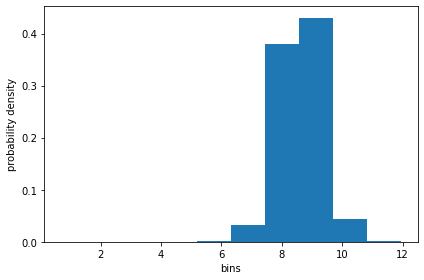

In [5]:
train['area'] = train['bbox'].apply(lambda arg: bbox_area(eval(arg)))
train['log_area'] = np.log(train['area'])
fig, ax = plt.subplots()
n, bins, pathces = plt.hist(train['log_area'].values, density=1)
ax.set_xlabel('bins')
ax.set_ylabel('probability density')
fig.tight_layout()
plt.show()

In [6]:
bins

array([ 0.69314718,  1.816811  ,  2.94047483,  4.06413865,  5.18780247,
        6.31146629,  7.43513012,  8.55879394,  9.68245776, 10.80612158,
       11.9297854 ])

In [7]:
train = train[(train['log_area'] > 6.2) & (train['log_area'] < 12)]
train.shape

(147312, 7)

In [8]:
'''
bins
train[(train['log_area'] > 12)]
'''

"\nbins\ntrain[(train['log_area'] > 12)]\n"

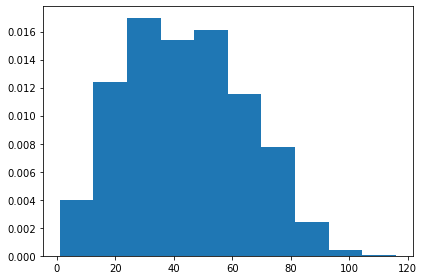

In [9]:
grouped = train.groupby(['source', 'image_id'])

fig, ax = plt.subplots()
n, bins, patches = plt.hist(grouped.apply(lambda group: len(group)).values, density=1)
fig.tight_layout()
plt.show()

In [10]:
bins

array([  1. ,  12.5,  24. ,  35.5,  47. ,  58.5,  70. ,  81.5,  93. ,
       104.5, 116. ])

In [11]:
bbox_cat = {'A': [0, 20], 'B': [20, 40], 'C': [40, 60], 'D': [60, 80], 'E': [80, 100]}

In [12]:
def map_bbox_cat(x):
    
    if x <= bbox_cat['A'][1]:
        return 'A'
    elif x <= bbox_cat['B'][1]:
        return 'B'
    elif x <= bbox_cat['C'][1]:
        return 'C'
    elif x <= bbox_cat['D'][1]:
        return 'D'
    else:
        return 'E'
        

In [13]:
grouped = grouped.apply(lambda group: map_bbox_cat(len(group)))
grouped = grouped.reset_index(name='box_cat')
grouped 

,source,image_id,box_cat
0,arvalis_1,00333207f,C
1,arvalis_1,00e903abe,C
2,arvalis_1,00ea5e5ee,C
3,arvalis_1,01189a3c3,B
4,arvalis_1,0126b7d11,B
...,...,...,...
3360,usask_1,f5093f57d,B
3361,usask_1,f6afe5443,B
3362,usask_1,f8e590769,B
3363,usask_1,fd5624913,B


In [14]:
grouped = grouped.groupby(['source', 'box_cat'])
grouped = grouped.apply(lambda group: group.sample(frac=0.2, random_state=42))
val_image_ids = grouped.reset_index(drop=True)['image_id']
len(val_image_ids)

670

In [15]:
train_df = train[~(train['image_id'].isin(val_image_ids))]
train_df.head()

,image_id,width,height,bbox,source,area,log_area
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,2016,7.608871
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,7540,8.927977
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,11840,9.379239
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,11663,9.364177
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,14508,9.582456


In [16]:
val_df = train[(train['image_id'].isin(val_image_ids))]
val_df.head()

,image_id,width,height,bbox,source,area,log_area
313,02b6f199c,1024,1024,"[832.0, 727.0, 90.0, 159.0]",usask_1,14310,9.568714
314,02b6f199c,1024,1024,"[286.0, 724.0, 79.0, 106.0]",usask_1,8374,9.032887
315,02b6f199c,1024,1024,"[955.0, 869.0, 69.0, 74.0]",usask_1,5106,8.538172
316,02b6f199c,1024,1024,"[138.0, 297.0, 76.0, 89.0]",usask_1,6764,8.819370
317,02b6f199c,1024,1024,"[848.0, 0.0, 77.0, 100.0]",usask_1,7700,8.948976


In [17]:
def get_img(img_path):
    
    img = cv.imread(img_path, cv.IMREAD_COLOR)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    return img

In [18]:
class GlobalWheatDetectionDataset(torch.utils.data.Dataset):
    
    def __init__(self, root, df, transforms=None):
        
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        
        self.imgs = sorted(list(df['image_id'].unique()))
        
        self.bboxs = {}
        
        for row in df.itertuples():
            if row[1] not in self.bboxs:
                self.bboxs[row.image_id] = [row.bbox]
            else:
                self.bboxs[row.image_id].append(row.bbox)
        

    def __getitem__(self, idx):
        
        # load images and convert to RGB
        img_path = os.path.join(self.root, "train", self.imgs[idx] + '.jpg')
        img = get_img(img_path).astype(np.float32)
        
        image_id = torch.tensor([idx])
        
        # get bounding box coordinates for each wheat head
        num_objs = len(self.bboxs[self.imgs[idx].split('.')[0]])
        boxes = []
        
        for box in self.bboxs[self.imgs[idx].split('.')[0]]:
            box = eval(box)
            xmin = box[0]
            xmax = box[0] + box[2]
            ymin = box[1]
            ymax = box[1] + box[3]
            boxes.append([xmin, ymin, xmax, ymax])
            
        if self.transforms:
            aug = {'image': img,  'bboxes': boxes, 'labels': [1]*num_objs}
            augmented = self.transforms(**aug)
            img = augmented['image']
            boxes = augmented['bboxes']

        img = torch.from_numpy(img)
        img = img.permute(2, 0, 1)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        return img, target

    def __len__(self):
        return len(self.imgs)

In [19]:
# dataset = GlobalWheatDetectionDataset('../input/global-wheat-detection/', train)
# dataset[0]

In [20]:
def get_transform(train):
    
    transforms = []
    
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(A.Flip(p=0.6))
        transforms.append(A.OneOf([A.HueSaturationValue(p=0.9), A.RGBShift(p=0.9),\
                                   A.RandomBrightnessContrast(p=0.9)], p=0.9))
        transforms.append(A.OneOf([A.GaussianBlur(blur_limit=5, p=0.9),\
                                   A.Blur(blur_limit=5, p=0.9)], p=0.01))
        
        transforms.append(A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5))
        
    transforms.append(A.Resize(512, 512))
    transforms.append(A.ToFloat(max_value=255.))
    return A.Compose(transforms, bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [21]:
def collate_fn(batch):
    return tuple(zip(*batch))

# use our dataset and defined transformations
dataset_train = GlobalWheatDetectionDataset('../input/global-wheat-detection/', train_df, get_transform(train=True))
dataset_val = GlobalWheatDetectionDataset('../input/global-wheat-detection/', val_df, get_transform(train=False))

# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=32, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=32, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

In [22]:
class Averager(object):
    
    def __init__(self, window_size=20, fmt='{avg:.4f} ({global_avg:.4f})'):
        
        self.values = deque(maxlen=window_size)
        self.total = 0.
        self.count = 0
        self.fmt = fmt
        pass
    
    def update(self, value):
        
        self.values.append(value)
        self.total = self.total + value
        self.count = self.count + 1
        pass
    
    @property
    def avg(self):
        d = torch.tensor(self.values, dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count
    
    def __str__(self):
        return self.fmt.format(avg=self.avg, \
                               global_avg=self.global_avg)
    

class TrainingLog(object):
    
    def __init__(self, delimiter=' '):
        
        self.metrics = defaultdict(Averager)
        self.delimiter = delimiter
        return
    
    def update(self, **loss_dict):
        
        for k, v in loss_dict.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.metrics[k].update(v)
        return
    
    def __str__(self):
        
        loss_str = []
        for k, v in self.metrics.items():
            loss_str.append('{}: {}'.format(k, str(v)))
        return self.delimiter.join(loss_str)
    
    def run_iterations(self, iterable, print_frq, header=''):
        
        i = 0
        start = time.time()
        end = time.time()
        log_msg = self.delimiter.join([header, '[{0}/{1}]', 'eta: {eta}', \
                                       '{metrics}','time: {time}',\
                                       'data: {data}'])
        data_time = Averager(fmt='{avg:.4f}')
        iter_time = Averager(fmt='{avg:.4f}')
        
        for obj in iterable:
            
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            
            if i % print_frq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                print(log_msg.format(i, len(iterable), eta=eta_string,\
                                     metrics=str(self), time=str(iter_time), \
                                     data=str(data_time)))
            i = i + 1
            end = time.time()
        
        total_time = time.time() - start
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {}'.format(header, total_time_str))
        
        return

In [23]:
@jit(nopython=True)
def IoU(pred, ann, fmt='coco'):

    axmin, aymin = pred[0], pred[1]
    bxmin, bymin = ann[0], ann[1]
    axmax, aymax = pred[2], pred[3]
    bxmax, bymax = ann[2], ann[3]
    if fmt == 'coco':
        axmax = axmax + axmin
        aymax = aymax + aymin
        bxmax = bxmax + bxmin
        bymax = bymax + bymin     
    dx = min(axmax, bxmax) - max(axmin, bxmin) + 1
    if dx < 0:
        return 0
    dy = min(aymax, bymax) - max(aymin, bymin) + 1
    if dy < 0:
        return 0
    overlap = dx * dy        
    area_union = (axmax - axmin + 1) * (aymax - aymin + 1) + \
                 (bxmax - bxmin + 1) * (bymax - bymin + 1) - \
                  overlap
    return overlap / area_union

@jit(nopython=True)
def precision_at(thld, preds, anns):
    
    thld = thld * 0.05 + 0.5
    metrics = np.zeros(4)
    available = np.ones(anns.shape[0])
    for idx in range(preds.shape[0]):
        pred = preds[idx]
        mx_iou = 0.
        mx_idx = -1
        for jdx in range(anns.shape[0]):
            ann = anns[jdx]
            if available[jdx] == 1:
                cur_iou = IoU(pred, ann)
                if cur_iou > mx_iou:
                    mx_iou = cur_iou
                    mx_idx = jdx
        if mx_iou >= thld:
            available[mx_idx] = 0 
            metrics[0] += 1 # True Positive
        else:
            metrics[1] += 1 # False Positive
    metrics[2] += np.count_nonzero(available) # False negative
    prec = metrics[0]/(metrics[0]+metrics[1]+metrics[2]) # precision
    return prec

@jit(nopython=True)
def precision_all(preds, anns):
    
    nthld = 6
    prec_at = np.zeros(6)
    for idx in range(nthld):
        prec_at[idx] = precision_at(idx, preds, anns)
    return prec_at, np.mean(prec_at)

@jit(nopython=True)
def sort_boxes(boxes, scores):
    qry = scores >= 0.5
    scores = scores[qry]
    scores = np.argsort(scores)[::-1]
    return boxes[scores]
    
class Evaluator(object):
    
    def __init__(self):
        
        self.nth = 6
        self.th = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]
        self.img_id_res = dict()
        self.img_prec = []
        self.map = 0.
        return
    
    def update(self, img_id, preds, anns):
        
        out = precision_all(preds, anns)
        self.img_id_res[str(img_id)] = out[0]
        self.img_prec.append(out[1])
        return True
    
    def update_batch(self, outputs, targets):
        
        for i, (output, target) in enumerate(zip(outputs, targets)):
            image_id = target['image_id'].numpy().astype(np.int32)
            p_boxes = output['boxes'].numpy().astype(np.int32)
            p_scores = output['scores'].numpy().astype(np.float32)
            t_boxes = target['boxes'].numpy().astype(np.int32)
            p_boxes = sort_boxes(p_boxes, p_scores)
            self.update(image_id, p_boxes, t_boxes)
        return True
            
    def summary(self):

        results = np.array(list(self.img_id_res.values()))
        mAP = np.mean(results, axis=0)
        for idx in range(mAP.shape[0]):
            print('mAP @[IoU={0:.2f}] = {1:.4f}'.format(self.th[idx], mAP[idx]))
        self.map = np.mean(np.array(self.img_prec))
        print('mAP @[IoU=0.50:0.75] = {0:.4f}'.format(self.map))
        return True            

In [24]:
'''
https://github.com/Bjarten/early-stopping-pytorch
'''

class EarlyStopping:
    
    def __init__(self, patience=10, verbose=True, delta=0.0001, path='fasterrcnn_resnet50_fpn512x512.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_mAP_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_mAP, model):

        score = val_mAP

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_mAP, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_mAP, model)
            self.counter = 0

    def save_checkpoint(self, val_mAP, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation mAP increased ({self.val_mAP_min:.4f} --> {val_mAP:.4f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_mAP_min = val_mAP

In [25]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [26]:

# our dataset has two classes only - background and wheat head
num_classes = 2
model_wt = '../input/fasterrcnn-resnet50-fpn-coco/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth'

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, \
                                                             pretrained_backbone=False,\
                                                             min_size=512, max_size=1024)
model.load_state_dict(torch.load(model_wt))
# get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(params, lr=0.0001, weight_decay=1e-5)

lr_scheduler = None

In [27]:
'''
checkpoint = '../input/gwd512x512/fasterrcnn_resnet50_fpnNBV22HW512x512.pth'
model.load_state_dict(torch.load(checkpoint, map_location=torch.device(device)))
'''

"\ncheckpoint = '../input/gwd512x512/fasterrcnn_resnet50_fpnNBV22HW512x512.pth'\nmodel.load_state_dict(torch.load(checkpoint, map_location=torch.device(device)))\n"

In [28]:
# let's train

num_epochs = 30
accumulation_steps = 2
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',\
                                                          patience=3,threshold_mode='abs',\
                                                          min_lr=1e-8,
                                                          verbose=True)
es = EarlyStopping()

for epoch in range(num_epochs):
    
    header = 'Epoch [{0}]'.format(epoch)
    training_log = TrainingLog()
    itr = 0
    model.train()
    
    for images, targets in training_log.run_iterations(data_loader_train, 100, header):

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        #itr = itr + 1
        losses = sum(loss for loss in loss_dict.values())
        # losses = losses / accumulation_steps
        losses.backward()
        #if itr % accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()
        training_log.update(loss=losses, **loss_dict)
    
    with torch.no_grad():

        evaluate = Evaluator()
        model.eval()

        header = 'Test'
        validation_log = TrainingLog()

        for images, targets in validation_log.run_iterations(data_loader_val, 100, header):
            images = list(image.to(device) for image in images)
            end = time.time()
            outputs = model(images)
            model_time = time.time() - end
            outputs = [{k: v.to("cpu") for k, v in t.items()} for t in outputs]
            end = time.time()
            evaluate.update_batch(outputs, targets)
            evaluator_time = time.time() - end
            validation_log.update(model_time=model_time, evaluator_time=evaluator_time)
            
        evaluate.summary()
    lr_scheduler.step(evaluate.map)
    es(evaluate.map, model)
    if es.early_stop:
        break

/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Epoch [0] [0/85] eta: 0:15:40 loss: 8.2019 (8.2019) loss_classifier: 0.6083 (0.6083) loss_box_reg: 0.1555 (0.1555) loss_objectness: 6.9878 (6.9878) loss_rpn_box_reg: 0.4504 (0.4504) time: 11.0688 data: 6.1210
Epoch [0] [84/85] eta: 0:00:02 loss: 1.5985 (1.7212) loss_classifier: 0.4832 (0.4873) loss_box_reg: 0.3408 (0.3335) loss_objectness: 0.5441 (0.6604) loss_rpn_box_reg: 0.2305 (0.2398) time: 2.0154 data: 0.1924
Epoch [0] Total time: 0:03:18
Test [0/21] eta: 0:03:37 model_time: 1.0336 (1.0336) evaluator_time: 5.3795 (5.3795) time: 10.3368 data: 3.8185
Test [20/21] eta: 0:00:01 model_time: 0.7479 (0.7615) evaluator_time: 0.0174 (0.2727) time: 1.0172 data: 0.1965
Test Total time: 0:00:30
mAP @[IoU=0.50] = 0.7429
mAP @[IoU=0.55] = 0.7358
mAP @[IoU=0.60] = 0.7260
mAP @[IoU=0.65] = 0.7124
mAP @[IoU=0.70] = 0.6917
mAP @[IoU=0.75] = 0.6611
mAP @[IoU=0.50:0.75] = 0.7116
Validation mAP increased (inf --> 0.7116).  Saving model ...
Epoch [1] [0/85] eta: 0:15:12 loss: 1.7626 (1.7626) loss_class

Epoch [9] [0/85] eta: 0:14:35 loss: 1.5066 (1.5066) loss_classifier: 0.4533 (0.4533) loss_box_reg: 0.3611 (0.3611) loss_objectness: 0.4622 (0.4622) loss_rpn_box_reg: 0.2301 (0.2301) time: 10.2949 data: 7.6599
Epoch [9] [84/85] eta: 0:00:02 loss: 1.3620 (1.3665) loss_classifier: 0.4077 (0.4073) loss_box_reg: 0.3382 (0.3385) loss_objectness: 0.4056 (0.4087) loss_rpn_box_reg: 0.2105 (0.2119) time: 2.0139 data: 0.1889
Epoch [9] Total time: 0:03:18
Test [0/21] eta: 0:01:38 model_time: 0.8069 (0.8069) evaluator_time: 0.0146 (0.0146) time: 4.7063 data: 3.7922
Test [20/21] eta: 0:00:01 model_time: 0.7921 (0.7928) evaluator_time: 0.0228 (0.0224) time: 1.1100 data: 0.2369
Test Total time: 0:00:26
mAP @[IoU=0.50] = 0.8323
mAP @[IoU=0.55] = 0.8260
mAP @[IoU=0.60] = 0.8182
mAP @[IoU=0.65] = 0.8059
mAP @[IoU=0.70] = 0.7908
mAP @[IoU=0.75] = 0.7642
mAP @[IoU=0.50:0.75] = 0.8062
Validation mAP increased (0.8013 --> 0.8062).  Saving model ...
Epoch [10] [0/85] eta: 0:13:54 loss: 1.4764 (1.4764) loss_cl

Epoch [18] [0/85] eta: 0:13:56 loss: 1.3228 (1.3228) loss_classifier: 0.3972 (0.3972) loss_box_reg: 0.3518 (0.3518) loss_objectness: 0.3692 (0.3692) loss_rpn_box_reg: 0.2047 (0.2047) time: 9.8426 data: 7.1647
Epoch [18] [84/85] eta: 0:00:02 loss: 1.2916 (1.3140) loss_classifier: 0.3834 (0.3911) loss_box_reg: 0.3267 (0.3316) loss_objectness: 0.3767 (0.3852) loss_rpn_box_reg: 0.2048 (0.2060) time: 1.9610 data: 0.1587
Epoch [18] Total time: 0:03:17
Test [0/21] eta: 0:02:12 model_time: 1.0595 (1.0595) evaluator_time: 0.0612 (0.0612) time: 6.3272 data: 5.1299
Test [20/21] eta: 0:00:01 model_time: 0.7722 (0.7859) evaluator_time: 0.0197 (0.0216) time: 1.0495 data: 0.1925
Test Total time: 0:00:27
mAP @[IoU=0.50] = 0.8473
mAP @[IoU=0.55] = 0.8410
mAP @[IoU=0.60] = 0.8337
mAP @[IoU=0.65] = 0.8220
mAP @[IoU=0.70] = 0.8067
mAP @[IoU=0.75] = 0.7818
mAP @[IoU=0.50:0.75] = 0.8221
Validation mAP increased (0.8205 --> 0.8221).  Saving model ...
Epoch [19] [0/85] eta: 0:14:12 loss: 1.3666 (1.3666) loss_

Epoch [27] [0/85] eta: 0:13:21 loss: 1.3782 (1.3782) loss_classifier: 0.4165 (0.4165) loss_box_reg: 0.3496 (0.3496) loss_objectness: 0.4061 (0.4061) loss_rpn_box_reg: 0.2060 (0.2060) time: 9.4252 data: 6.5190
Epoch [27] [84/85] eta: 0:00:02 loss: 1.2840 (1.2808) loss_classifier: 0.3804 (0.3797) loss_box_reg: 0.3223 (0.3260) loss_objectness: 0.3798 (0.3719) loss_rpn_box_reg: 0.2015 (0.2032) time: 1.9931 data: 0.1819
Epoch [27] Total time: 0:03:17
Test [0/21] eta: 0:01:59 model_time: 1.0014 (1.0014) evaluator_time: 0.0480 (0.0480) time: 5.6925 data: 4.5556
Test [20/21] eta: 0:00:01 model_time: 0.8027 (0.8121) evaluator_time: 0.0229 (0.0241) time: 1.0880 data: 0.1962
Test Total time: 0:00:27
mAP @[IoU=0.50] = 0.8559
mAP @[IoU=0.55] = 0.8516
mAP @[IoU=0.60] = 0.8457
mAP @[IoU=0.65] = 0.8326
mAP @[IoU=0.70] = 0.8196
mAP @[IoU=0.75] = 0.7918
mAP @[IoU=0.50:0.75] = 0.8329
EarlyStopping counter: 1 out of 10
Epoch [28] [0/85] eta: 0:14:07 loss: 1.2108 (1.2108) loss_classifier: 0.3658 (0.3658) l

In [29]:
#torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

# Inference

In [30]:
'''
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False,\
                                                             pretrained_backbone=False,\
                                                             min_size=512, max_size=1024)
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

# Load the trained weights
WEIGHTS_FILE = '../input/ghdoutputv8/fasterrcnn_resnet50_fpn.pth'
model.load_state_dict(torch.load(WEIGHTS_FILE, map_location=torch.device(device)))
'''

"\nmodel = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False,                                                             pretrained_backbone=False,                                                             min_size=512, max_size=1024)\nin_features = model.roi_heads.box_predictor.cls_score.in_features\n\n# replace the pre-trained head with a new one\nmodel.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)\n\n# Load the trained weights\nWEIGHTS_FILE = '../input/ghdoutputv8/fasterrcnn_resnet50_fpn.pth'\nmodel.load_state_dict(torch.load(WEIGHTS_FILE, map_location=torch.device(device)))\n"

In [31]:
'''root = '/kaggle/input/global-wheat-detection/'
imgs = os.listdir(root + 'train')'''

"root = '/kaggle/input/global-wheat-detection/'\nimgs = os.listdir(root + 'train')"

In [32]:
'''def get_prediction(img, th=None):
    
    if isinstance(img, str):
        img = get_img(img)
        img = img.astype(np.float32)
        img = img / 255.0
        img = torch.from_numpy(img)
        img = img.permute(2, 0, 1)
    
    output = model([img])
    
    with torch.no_grad():
        bboxes = output[0]['boxes'].detach().numpy().astype(np.int32)
        score = output[0]['scores'].detach().numpy()
        
        bboxes[:, 2] = bboxes[:, 2] - bboxes[:, 0]
        bboxes[:, 3] = bboxes[:, 3] - bboxes[:, 1]
        
        if th:
            qry = score >= th
            bboxes = bboxes[qry]
            score = score[qry]
            print(score.shape, bboxes.shape)
        
    return bboxes, score ''' 

"def get_prediction(img, th=None):\n    \n    if isinstance(img, str):\n        img = get_img(img)\n        img = img.astype(np.float32)\n        img = img / 255.0\n        img = torch.from_numpy(img)\n        img = img.permute(2, 0, 1)\n    \n    output = model([img])\n    \n    with torch.no_grad():\n        bboxes = output[0]['boxes'].detach().numpy().astype(np.int32)\n        score = output[0]['scores'].detach().numpy()\n        \n        bboxes[:, 2] = bboxes[:, 2] - bboxes[:, 0]\n        bboxes[:, 3] = bboxes[:, 3] - bboxes[:, 1]\n        \n        if th:\n            qry = score >= th\n            bboxes = bboxes[qry]\n            score = score[qry]\n            print(score.shape, bboxes.shape)\n        \n    return bboxes, score "

In [33]:
'''imgs = list(set(os.listdir(root + 'train')).difference(\
                                                       set(list(\
                                                                map(lambda arg: arg + '.jpg', \
                                                                    list(train['image_id'].unique()))))))
'''


# 00b5c6764.jpg 155c440e8.jpg d771bb084.jpg ed00a614d.jpg c18c32da0.jpg
# 0cf7ef43d.jpg

"imgs = list(set(os.listdir(root + 'train')).difference(                                                       set(list(                                                                map(lambda arg: arg + '.jpg',                                                                     list(train['image_id'].unique()))))))\n"

In [34]:
# bb1c3ce8f.jpg ca5e51e59.jpg

In [35]:
'''idx = 2016
img = imgs[idx]
print(img)
bbox = train[(train['image_id'] == img.split('.')[0])]['bbox']
bbox = list(bbox.values)
bbox = list(map(lambda arg: eval(arg), bbox))
img_path = os.path.join(root, 'train', img)
pred, _ = get_prediction(img_path, th=0.5)
print(len(bbox))
img = viz_bbox(img_path, bbox)
img = viz_bbox(img, pred, box_color=(0, 0, 255))
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

evaluate = Evaluator()
evaluate.update(idx, pred, bbox)
evaluate.summary()
'''
'''plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(plt.imread(img_path))
plt.subplot(122)
plt.imshow(viz_bbox(img_path, pred))
plt.show()'''

'plt.figure(figsize=(15, 15))\nplt.subplot(121)\nplt.imshow(plt.imread(img_path))\nplt.subplot(122)\nplt.imshow(viz_bbox(img_path, pred))\nplt.show()'

In [36]:
'''annotations = {'image': get_img(img_path)}'''

"annotations = {'image': get_img(img_path)}"

In [37]:
'''aug = A.Compose([A.Crop(p=1, x_min=512, y_min=512, x_max=1024, y_max=1024)])
augmented = aug(**annotations)

plt.figure(figsize=(10, 10))
plt.imshow(augmented['image'])
plt.show()'''


"aug = A.Compose([A.Crop(p=1, x_min=512, y_min=512, x_max=1024, y_max=1024)])\naugmented = aug(**annotations)\n\nplt.figure(figsize=(10, 10))\nplt.imshow(augmented['image'])\nplt.show()"

In [38]:
'''img = torch.from_numpy(augmented['image'].astype(np.float32) / 255.)
img = img.permute(2, 0, 1)
pred = get_prediction(img)'''

"img = torch.from_numpy(augmented['image'].astype(np.float32) / 255.)\nimg = img.permute(2, 0, 1)\npred = get_prediction(img)"

In [39]:
'''pred'''

'pred'